# Introduction
> **GOAL: Develop a machine learning model to predict the source of a data packet.**

In this section we develop learning model(s) for our device identification problem. We load the dataset from feather files that we saved in the Data Wrangling section.

In [1]:
%matplotlib inline

import numpy as np  
import pandas as pd

from sklearn.model_selection import train_test_split


In [2]:
EXTRACTED_PCAP_PATH = './feathers/16-09-23.pcap.feather'
df = pd.read_feather(EXTRACTED_PCAP_PATH)

# Data Exploration
I this section we explore the data columns further and end up removing ten more columns further.

In [3]:
df.shape

(947072, 60)

In [4]:
low_unique_value_columns = df[df.columns].nunique()/(df ==0).sum()

In [5]:
low_unique_value_columns.sort_values()[:20]

ip.dsfield.ecn              0.000001
ip.flags.rb                 0.000001
ip.flags.mf                 0.000002
tcp.flags.reset             0.000002
tcp.flags.fin               0.000002
tcp.flags.syn               0.000002
tcp.flags.push              0.000003
ip.frag_offset              0.000003
tcp.analysis.initial_rtt    0.000005
frame.time_delta            0.000005
tcp.flags.ack               0.000008
tcp.checksum.status         0.000008
ip.dsfield.dscp             0.000008
ip.dsfield                  0.000008
ip.flags.df                 0.000011
ip.checksum.status          0.000018
ip.flags                    0.000021
tcp.analysis.ack_rtt        0.000023
ip.hdr_len                  0.000027
ip.version                  0.000042
dtype: float64

In [6]:
# Thus, we decide to further delete these columns as well.

cols_to_drop = ["ip.flags.rb","ip.dsfield.ecn","ip.flags.mf",
                "tcp.flags.reset","tcp.flags.fin","tcp.flags.syn",
                "tcp.flags.push","ip.frag_offset","tcp.flags.ack",
                "tcp.checksum.status"]

In [7]:
df.drop(columns=cols_to_drop, inplace=True)
df.shape

(947072, 50)

# Testing out Learning Models- I

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [9]:
TEST_SIZE = 0.2

X_train, X_test, y_train, y_test = train_test_split(
    df.loc[:, df.columns.difference(['eth.src'])], 
    df['eth.src'],
    test_size=TEST_SIZE)

In [10]:
assert y_train.nunique() >= y_test.nunique(), \
                    "WARN: This means that some classes\
                    are not present in the training set but\
                    are present in the test set"

In [42]:
RF = RandomForestClassifier(n_estimators=20)

In [43]:
RF.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [44]:
res = RF.predict(X_test)
accuracy_score(y_test, res, normalize=True)

0.986458305836391

### Discussion
Upon realizing the >0.99 accuracy, we plan to make the learning problem a bit more difficult by removing certain columns which are highly correlated with the target label i.e. `eth.src`

In [14]:
df.corr()['eth.src'].sort_values()

tcp.dstport                    -0.376963
tcp.time_relative              -0.298453
eth.dst                        -0.257750
ip.id                          -0.230737
ip.len                         -0.217475
tcp.nxtseq                     -0.213376
tcp.seq                        -0.213371
frame.len                      -0.201500
tcp.len                        -0.198343
tcp.hdr_len                    -0.183476
tcp.window_size_scalefactor    -0.176216
tcp.analysis.bytes_in_flight   -0.171085
eth.dst.oui                    -0.152728
tcp.analysis.push_bytes_sent   -0.115878
ip.flags.df                    -0.111405
ip.flags                       -0.111288
udp.dstport                    -0.085241
tcp.segment                    -0.080609
tcp.segment.count              -0.048333
tcp.reassembled.length         -0.045555
ip.checksum.status             -0.039895
ip.hdr_len                     -0.039051
frame.time_delta               -0.017092
udp.length                     -0.011317
ip.dsfield.dscp 

In [45]:
columns_to_hide = ['eth.src', 
                   'eth.dst', 
                   'ip.src', 
                   'ip.dst',
                   'eth.src.oui',
                   'eth.dst.oui']

In [46]:
TEST_SIZE = 0.2

X_train, X_test, y_train, y_test = train_test_split(
    df.loc[:, df.columns.difference(columns_to_hide)], 
    df['eth.src'],
    test_size=TEST_SIZE)

In [47]:
RF.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [48]:
res = RF.predict(X_test)
accuracy_score(y_test, res, normalize=True)

0.9309294406462001

In [18]:
print("Total number of devices = {devices}".format(devices=df['eth.src'].nunique()))
print("Total number of rows = {rows}".format(rows=df.index.size))

Total number of devices = 22
Total number of rows = 947072


### Summary and Discussion
We realize that we are able to get an accuracy of 99% with all the columns, and an accuracy of 93% when the columns with strong correlation with the target label (`eth.src`) are removed.

# Finding Best Models 
In this section, we try to pick up models that would perform the best on our dataset.

In [94]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

from sklearn.neural_network import MLPClassifier

In [100]:
from datetime import datetime
models = [{"name": "k-Nearest Neighbor",
        "model": KNeighborsClassifier,
        "time_taken": ""},
        {"name": "Random Forest Classifier",
        "model": RandomForestClassifier,
        "time_taken": ""},
        #{"name": "Gradient Boosting Classifier",
        #"model": GradientBoostingClassifier,
        #"time_taken": "",
        #"params": {'max_features': 'auto'}},
        {"name": "Multi-layer Perceptron",
        "model": MLPClassifier,
        "time_taken": ""}]

In [101]:
for model in models:
    time = datetime.now()
    params = model.get('params', None)
    if params:
        model["model"] = model["model"](**params)
    else:
        model["model"] = model["model"]()
        
    print("\n\n-> Training model: ", model["model"])
    
    model["model"].fit(X_train, y_train)
    model["time_taken"] = datetime.now()-time
    
    print("->> Time taken ", model["time_taken"])



-> Training model:  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
->> Time taken  0:08:59.200159


-> Training model:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
->> Time taken  0:05:05.248052


-> Training model:  MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e

### TODO

1. Check over-under fitting classes [tick]
2. Check hyper-parameter tuning


In [108]:
for model in models:
    print("Model is ", model['name'])
    print(accuracy_score(y_test, model['model'].predict(X_test)))

Model is  k-Nearest Neighbor
0.9160890109019877
Model is  Random Forest Classifier
0.9321753820975107
Model is  Multi-layer Perceptron
0.45047118760393845


In [120]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

model = models[1]['model']
#cnfmat = confusion_matrix(y_test, model.predict(X_test), labels=y_test.unique())

<Figure size 6000x6000 with 0 Axes>

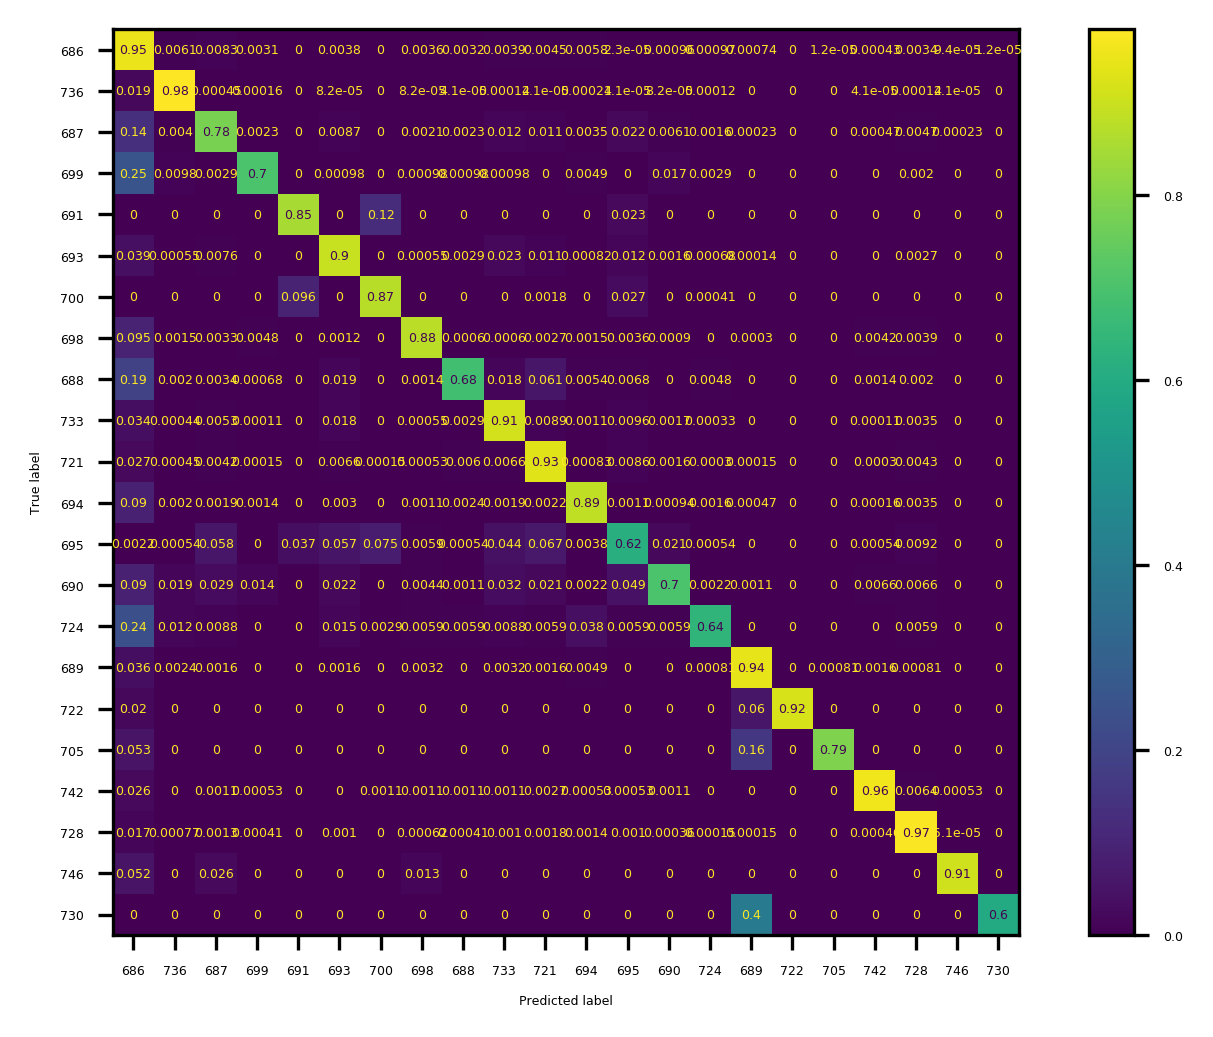

In [133]:
%matplotlib inline

plt.rcParams['figure.dpi'] = 300
plt.figure(figsize=(20,20))
plt.rcParams.update({'font.size': 3})

plot_confusion_matrix(model, 
                      X_test, 
                      y_test,
                      display_labels=y_test.unique(),
                      normalize='true')

plt.show()

# Testing and Interpreting the Best Model
In this section, we explore our best performing model in two different ways:
1. As a standard random train/test on the entire dataset.
2. Training on data collected on early days and predicting data at a later point in time.